# Data Pre-Processing

In [108]:
import pathlib
import fastparquet
import pyarrow
import requests
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from category_encoders import OrdinalEncoder
import multiprocessing
warnings.filterwarnings('ignore')

In [109]:
DATA_DIR = pathlib.Path.cwd().parent / 'fetch_data'
DATA_DIR.mkdir(parents=True, exist_ok=True)

SAVE_PATH = DATA_DIR / 'data.csv'

In [110]:
source_url = 'https://www.openintro.org/book/statdata/ames.csv'
headers = {
    'User-Agent': \
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) ' \
        'AppleWebKit/537.36 (KHTML, like Gecko) ' \
        'Chrome/39.0.2171.95 Safari/537.36',
}
response = requests.get(source_url, headers=headers)
csv_content = response.content.decode()
with open(SAVE_PATH, 'w', encoding='utf8') as file:
    file.write(csv_content)

In [111]:
data = pd.read_csv(SAVE_PATH)

df = data.copy()

In [112]:
# APENAS PARA ANALISE

df.head()

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [113]:
# APENAS PARA ANALISE

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Order,2930.0,1.465500e+03,8.459625e+02,1.0,7.332500e+02,1465.5,2.197750e+03,2.930000e+03
PID,2930.0,7.144645e+08,1.887308e+08,526301100.0,5.284770e+08,535453620.0,9.071811e+08,1.007100e+09
MS.SubClass,2930.0,5.738737e+01,4.263802e+01,20.0,2.000000e+01,50.0,7.000000e+01,1.900000e+02
Lot.Frontage,2440.0,6.922459e+01,2.336533e+01,21.0,5.800000e+01,68.0,8.000000e+01,3.130000e+02
Lot.Area,2930.0,1.014792e+04,7.880018e+03,1300.0,7.440250e+03,9436.5,1.155525e+04,2.152450e+05
Overall.Qual,2930.0,6.094881e+00,1.411026e+00,1.0,5.000000e+00,6.0,7.000000e+00,1.000000e+01
Overall.Cond,2930.0,5.563140e+00,1.111537e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.000000e+00
Year.Built,2930.0,1.971356e+03,3.024536e+01,1872.0,1.954000e+03,1973.0,2.001000e+03,2.010000e+03
Year.Remod.Add,2930.0,1.984267e+03,2.086029e+01,1950.0,1.965000e+03,1993.0,2.004000e+03,2.010000e+03
Mas.Vnr.Area,2907.0,1.018968e+02,1.791126e+02,0.0,0.000000e+00,0.0,1.640000e+02,1.600000e+03


In [114]:
# APENAS PARA ANALISE

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS.SubClass      2930 non-null   int64  
 3   MS.Zoning        2930 non-null   object 
 4   Lot.Frontage     2440 non-null   float64
 5   Lot.Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot.Shape        2930 non-null   object 
 9   Land.Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot.Config       2930 non-null   object 
 12  Land.Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition.1      2930 non-null   object 
 15  Condition.2      2930 non-null   object 
 16  Bldg.Type        2930 non-null   object 
 17  House.Style   

In [115]:
# APENAS PARA ANALISE

df.dtypes.value_counts()

object     43
int64      28
float64    11
Name: count, dtype: int64

In [116]:
df.drop(columns=['Order', 'PID'], inplace=True)

<Axes: >

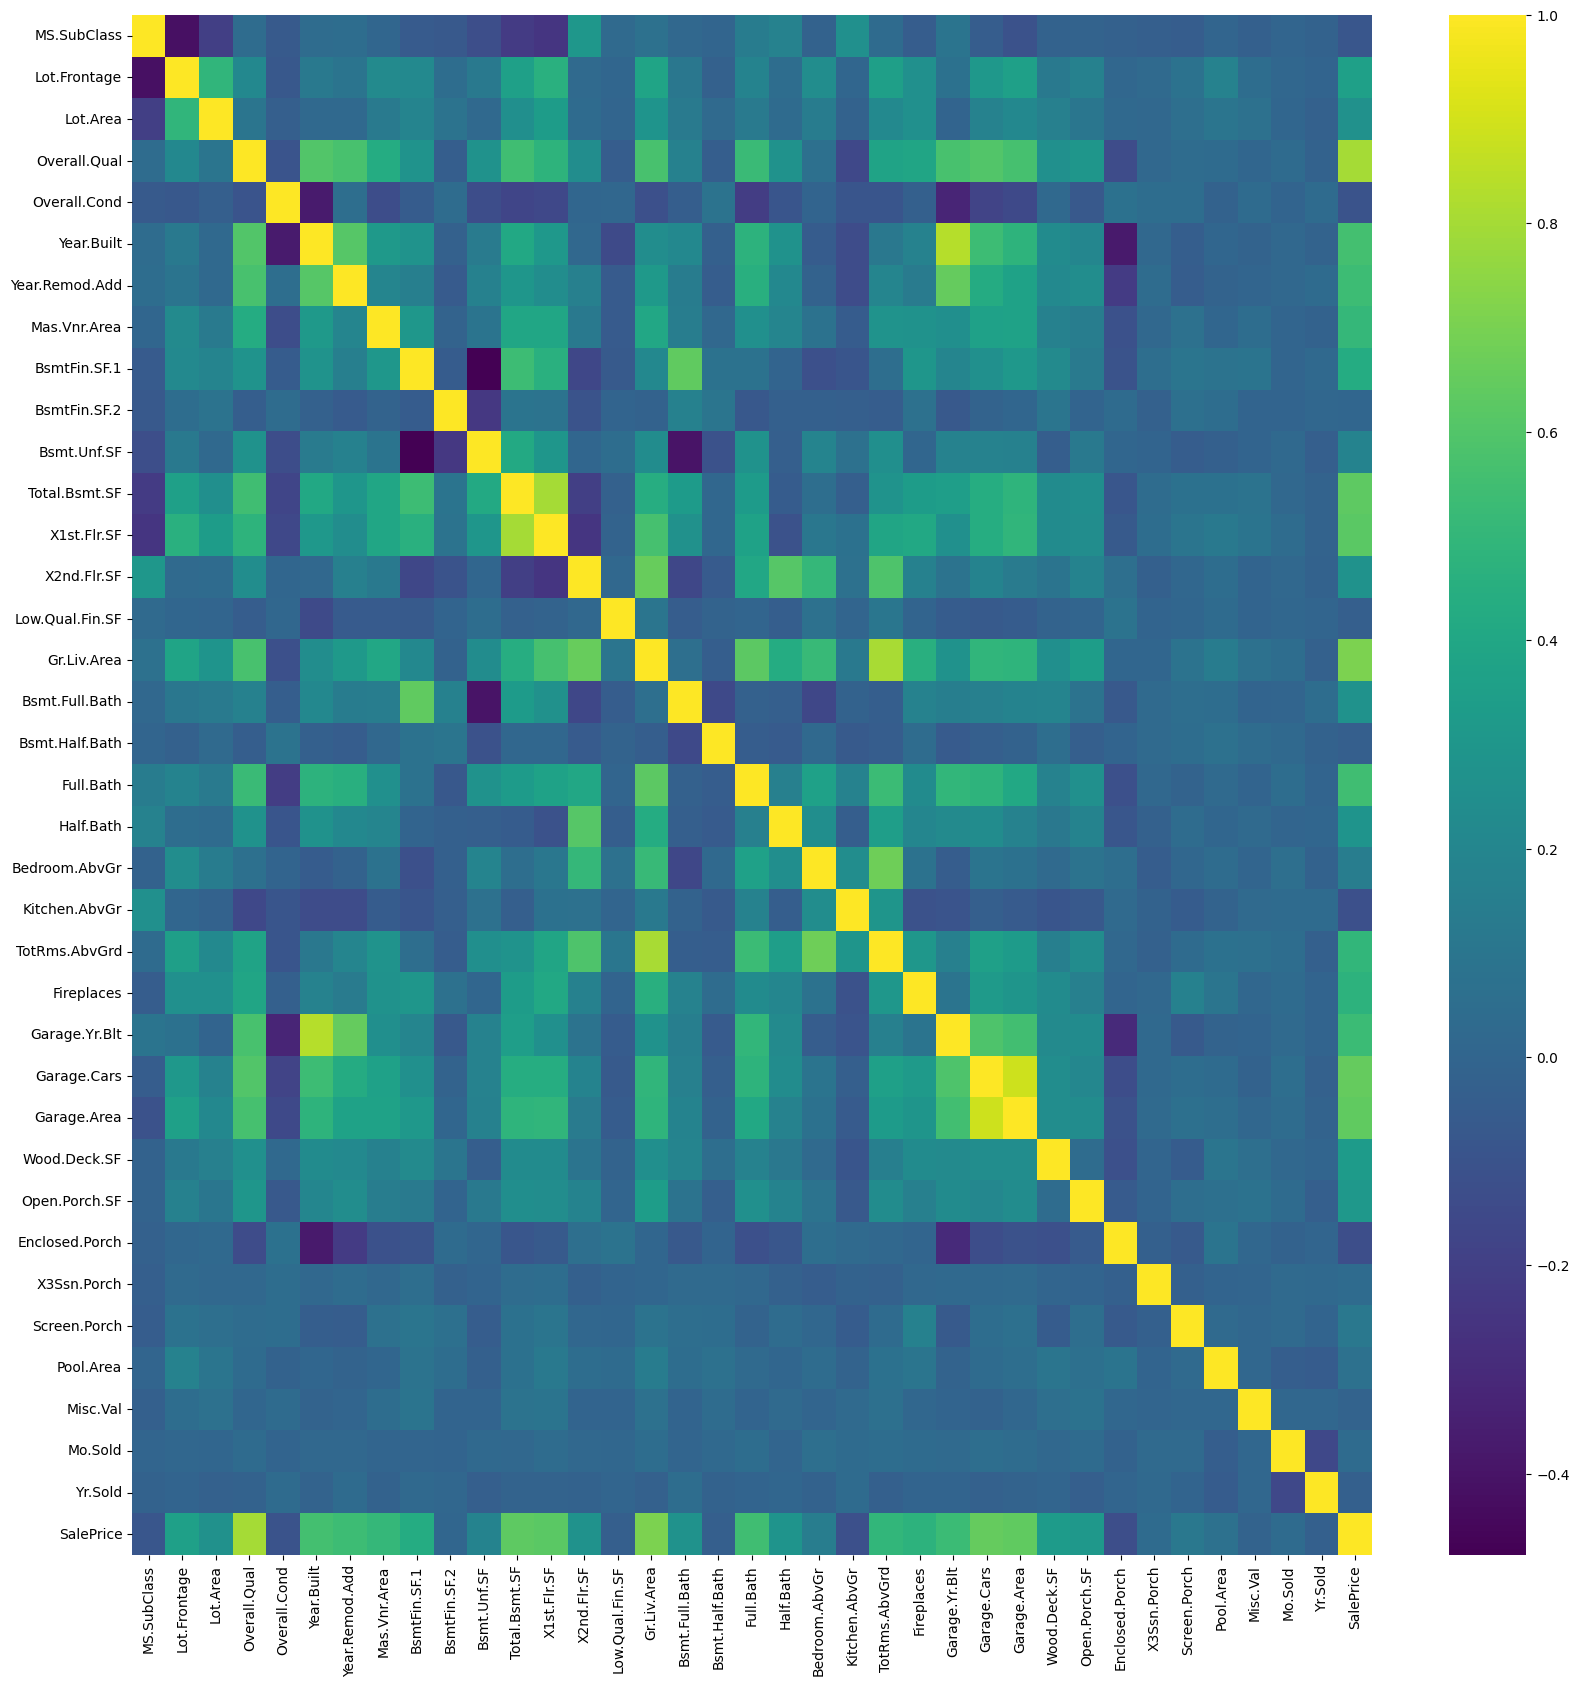

In [117]:
# APENAS PARA ANALISE

plt.figure(figsize=(20, 20))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='viridis')

<Axes: >

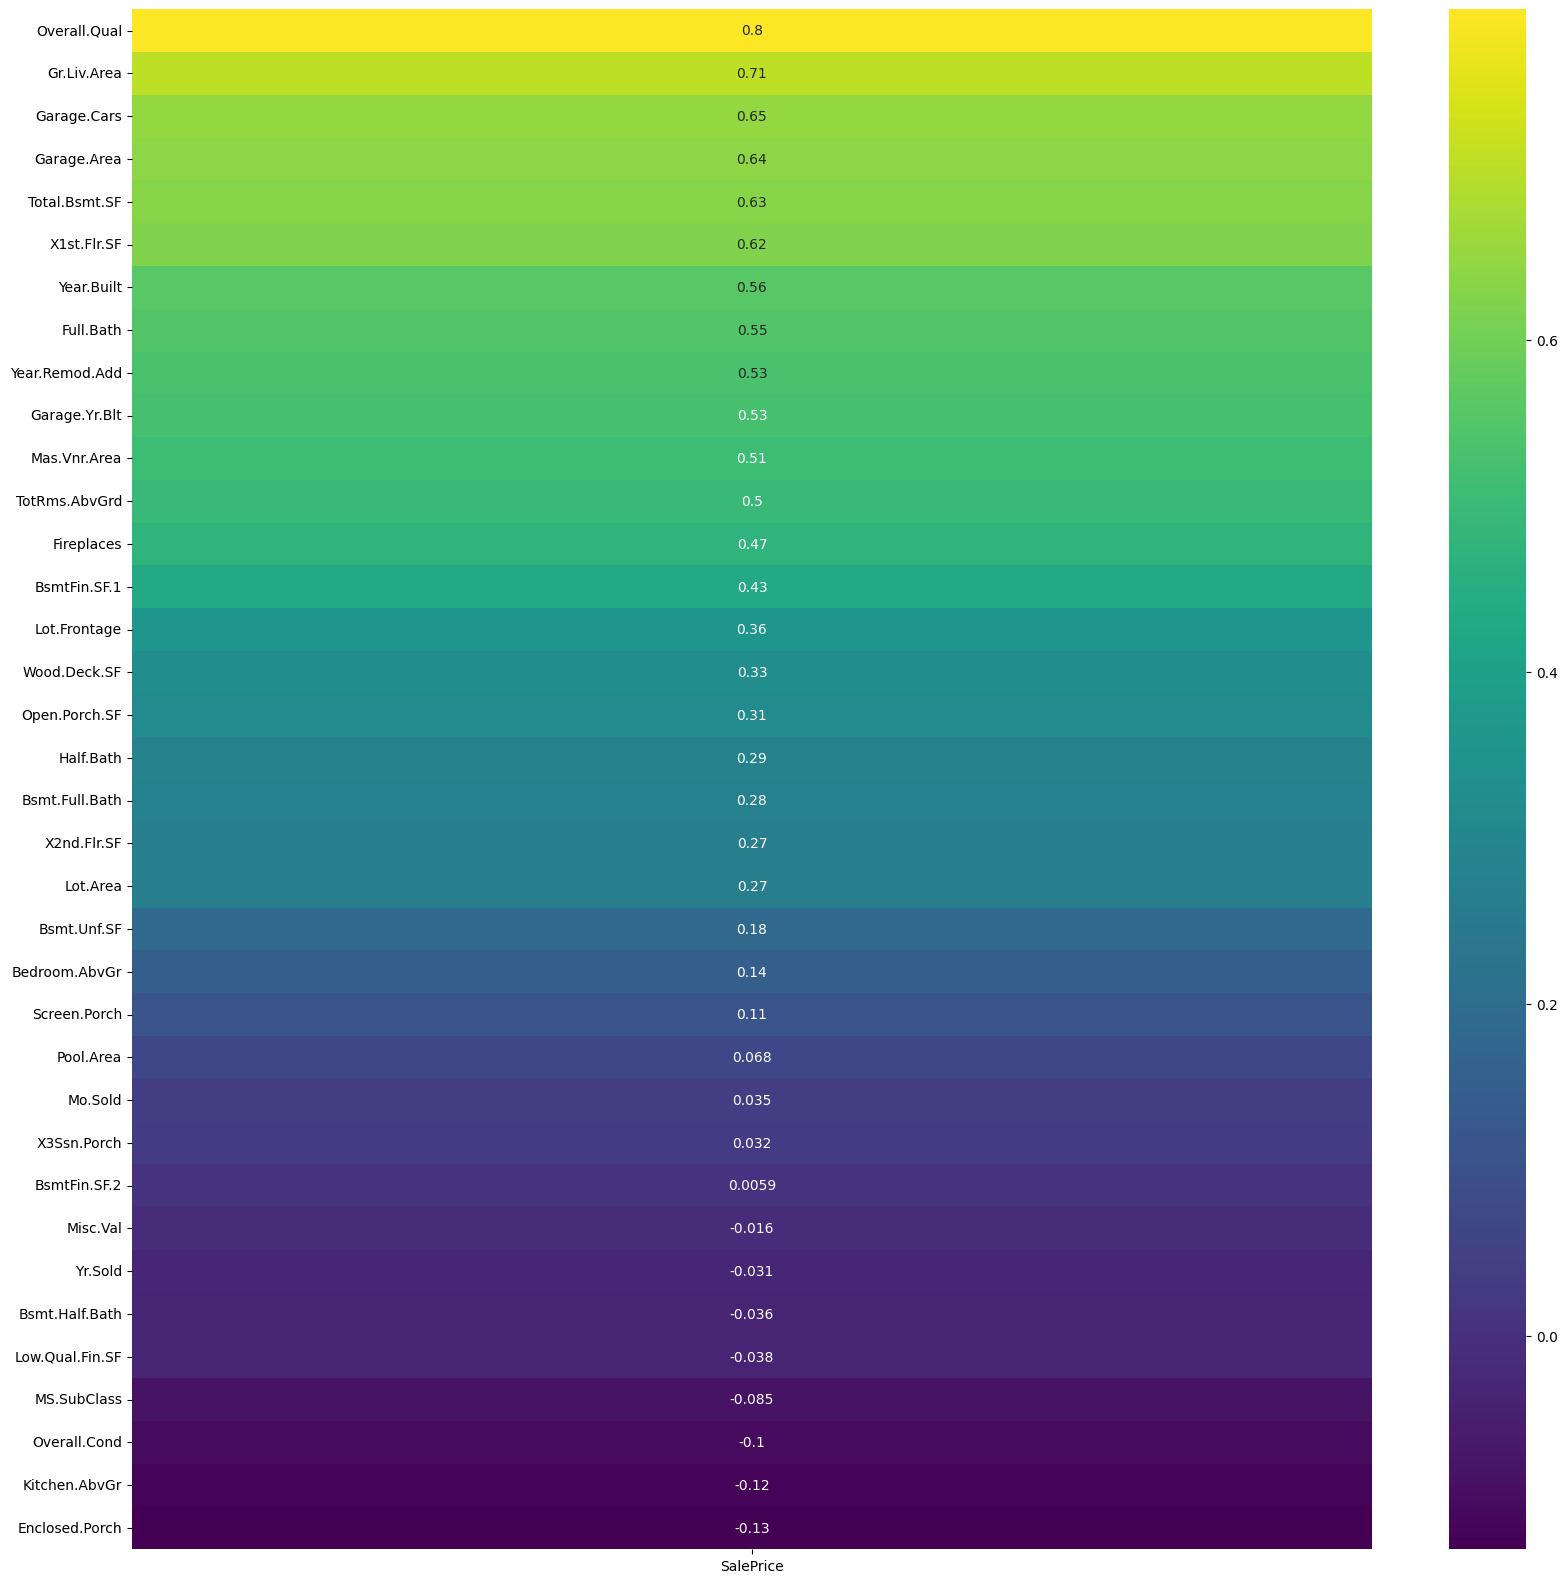

In [118]:
# APENAS PARA ANALISE

df_num = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20, 20))
corr = df_num.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)
corr.drop(index='SalePrice', inplace=True)
sns.heatmap(corr, cmap='viridis', annot=True)

<Axes: xlabel='Sale.Type', ylabel='SalePrice'>

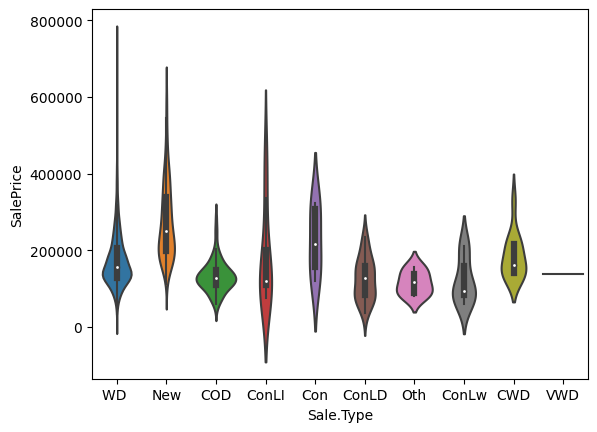

In [119]:
# APENAS PARA ANALISE

sns.violinplot(x='Sale.Type', y='SalePrice', data=df)

<Axes: xlabel='Year.Built', ylabel='SalePrice'>

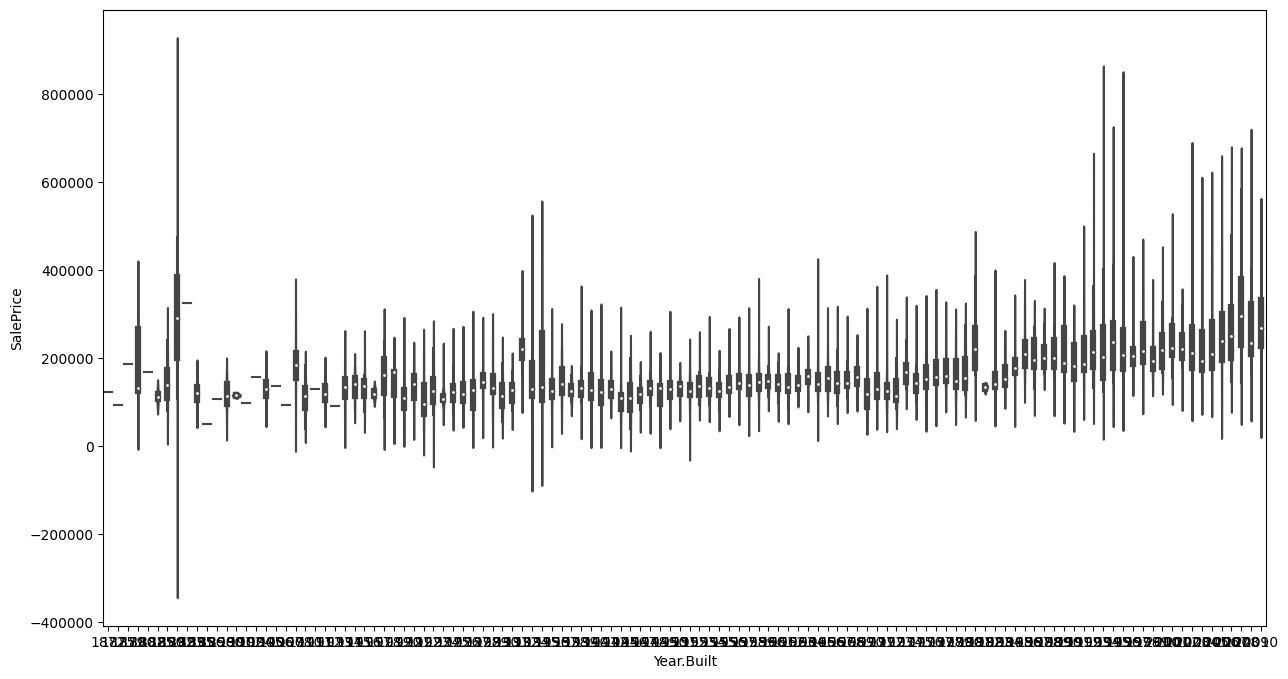

In [120]:
# APENAS PARA ANALISE

plt.figure(figsize=(15, 8))
sns.violinplot(x='Year.Built', y='SalePrice', data=df)

<Axes: xlabel='Neighborhood', ylabel='SalePrice'>

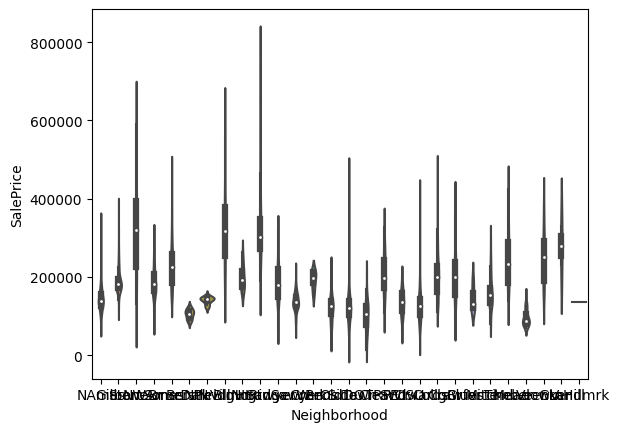

In [121]:
# APENAS PARA ANALISE

sns.violinplot(x='Neighborhood', y='SalePrice', data=df)

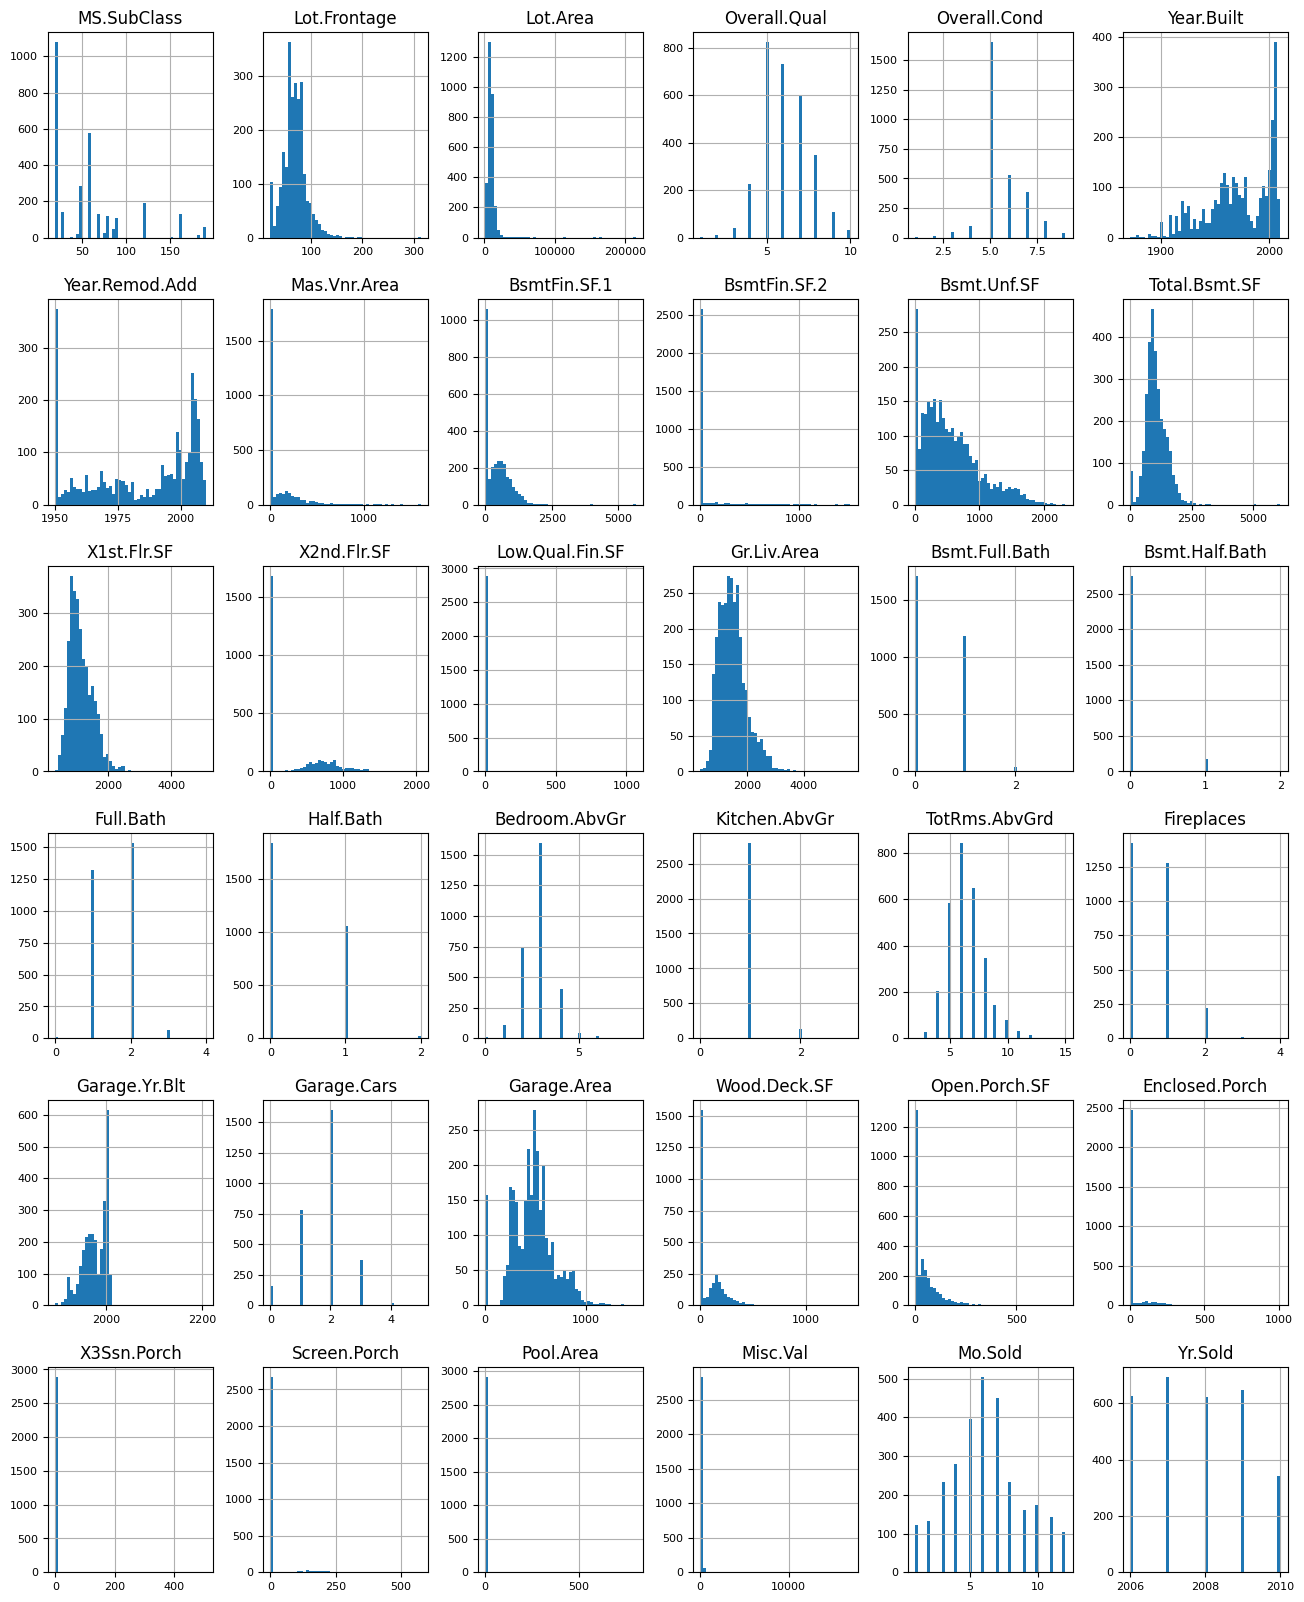

In [122]:
# APENAS PARA ANALISE

X_num = df.select_dtypes(include=['int64', 'float64'])

X_num.drop(columns=['SalePrice'], inplace=True)

X_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

<Axes: >

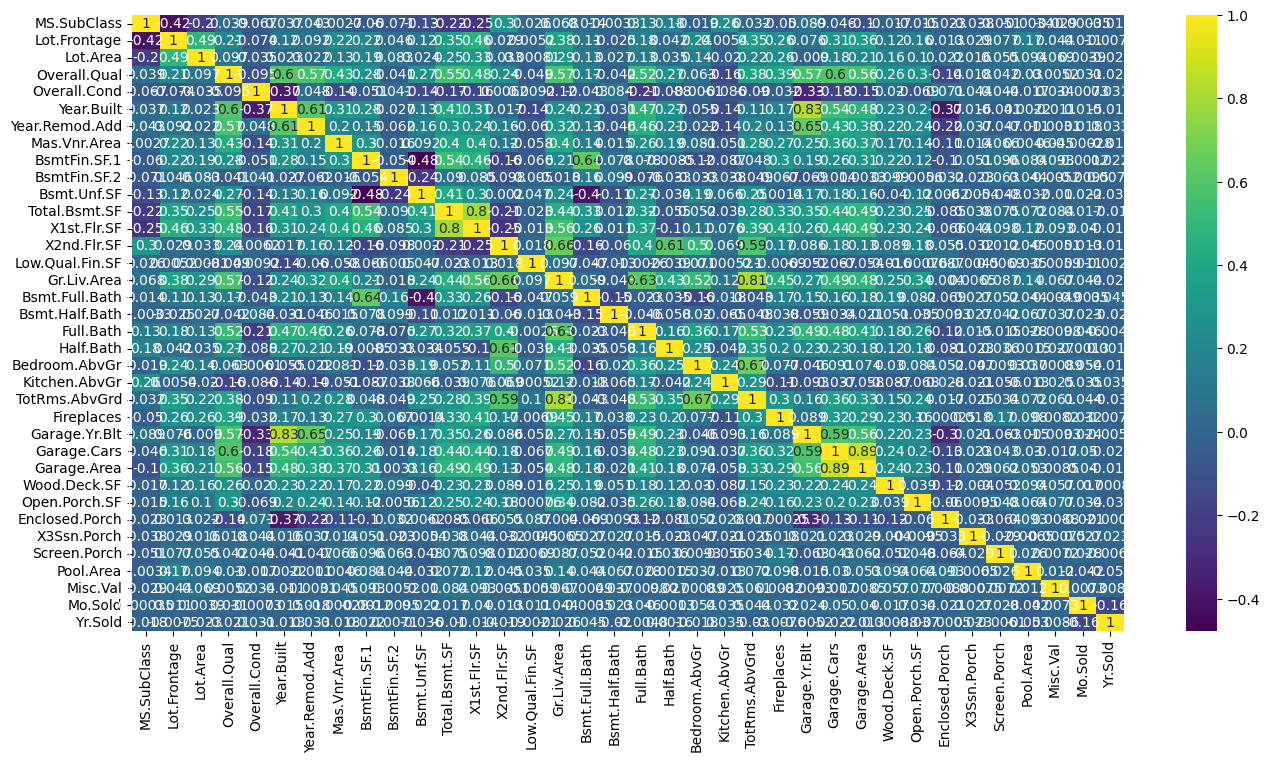

In [123]:
# APENAS PARA ANALISE

plt.figure(figsize=(16, 8))
corr = X_num.corr()
sns.heatmap(corr, cmap='viridis', annot=True)

In [124]:
# APENAS PARA ANALISE

df_nan = df.isna().sum().to_frame('nan_count')

df_nan['type'] = df.dtypes

df_nan.sort_values(by='nan_count', ascending=False, inplace=True)

df_nan = df_nan[df_nan['nan_count'] != 0]

df_nan

,nan_count,type
Pool.QC,2917,object
Misc.Feature,2824,object
Alley,2732,object
Fence,2358,object
Mas.Vnr.Type,1775,object
Fireplace.Qu,1422,object
Lot.Frontage,490,float64
Garage.Cond,159,object
Garage.Yr.Blt,159,float64
Garage.Finish,159,object


In [125]:
ordinal_variables = [
    'Lot.Shape',
    'Utilities',
    'Land.Slope',
    'Overall.Qual',
    'Overall.Cond',
    'Exter.Qual',
    'Exter.Cond',
    'Bsmt.Qual',
    'Bsmt.Cond',
    'Bsmt.Exposure',
    'BsmtFin.Type.1',
    'BsmtFin.Type.2',
    'Heating.QC',
    'Electrical',
    'Kitchen.Qual',
    'Functional',
    'Fireplace.Qu',
    'Garage.Finish',
    'Garage.Qual',
    'Garage.Cond',
    'Paved.Drive',
    'Pool.QC',
    'Fence',
]

categorical_variables = [
    'MS.SubClass',
    'MS.Zoning',
    'Street',
    'Alley',
    'Land.Contour',
    'Lot.Config',
    'Neighborhood',
    'Condition.1',
    'Condition.2',
    'Bldg.Type',
    'House.Style',
    'Roof.Style',
    'Roof.Matl',
    'Exterior.1st',
    'Exterior.2nd',
    'Mas.Vnr.Type',
    'Foundation',
    'Heating',
    'Central.Air',
    'Garage.Type',
    'Misc.Feature',
    'Sale.Type',
    'Sale.Condition',
]

fill_none = [
    'Pool.QC',
    'Misc.Feature',
    'Alley',
    'Fence',
    'Fireplace.Qu',
    'Garage.Finish',
    'Garage.Qual',
    'Garage.Cond',
    'Garage.Finish',
    'Garage.Qual',
    'Garage.Cond',
    'Garage.Type'
]

fill_no_bsmt = [
    'Bsmt.Qual',
    'Bsmt.Cond',
    'Bsmt.Exposure',
    'BsmtFin.Type.1',
    'BsmtFin.Type.2',
]

fill_mode = [
    'Electrical',
    'Functional',
    'Kitchen.Qual',
    'Exterior.1st',
    'Exterior.2nd',
    'MS.Zoning',
    'Sale.Type',
    'Mas.Vnr.Type'
]

In [126]:
for col in fill_none:
    df[col].fillna('None', inplace=True)

for col in fill_no_bsmt:
    df[col].fillna('NoBsmt', inplace=True)

for col in fill_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [127]:
df_nan = df.isna().sum().to_frame('nan_count')

df_nan['type'] = df.dtypes

df_nan.sort_values(by='nan_count', ascending=False, inplace=True)
cols_nan = df_nan[df_nan['nan_count'] != 0].index.tolist()
cols_nonan = df_nan[df_nan['nan_count'] == 0].index.tolist()

In [128]:
df_num = df.select_dtypes(include=np.number)
df_cat = df.select_dtypes(exclude=np.number)

for col in cols_nan:
    impute = df_num[df_num[col].isna()]
    imputer_train = df_num[~df_num[col].isna()]
    
    # Certifique-se de que cols_nonan esteja presente em ambos os DataFrames
    cols_nonan = [col for col in cols_nonan if col in df_num.columns]
    
    imputer = KNeighborsRegressor(n_neighbors=5)
    knr = imputer.fit(imputer_train[cols_nonan], imputer_train[col])
    df_num.loc[impute.index, col] = knr.predict(impute[cols_nonan])

df = pd.concat([df_num, df_cat], axis=1)

In [129]:
selection = ~(df['MS.Zoning'].isin(['A (agr)', 'C (all)', 'I (all)']))
df = df[selection]

In [130]:
# APENAS PARA ANALISE
print(df.shape)
df.head()

(2901, 80)


,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,...,Garage.Type,Garage.Finish,Garage.Qual,Garage.Cond,Paved.Drive,Pool.QC,Fence,Misc.Feature,Sale.Type,Sale.Condition
0,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,...,Attchd,Fin,TA,TA,P,None,None,None,WD,Normal
1,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,Attchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal
2,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,Attchd,Unf,TA,TA,Y,None,None,Gar2,WD,Normal
3,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,...,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal
4,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,Attchd,Fin,TA,TA,Y,None,MnPrv,None,WD,Normal


In [131]:
# APENAS PARA ANALISE

df_nan = df.isna().sum().to_frame('nan_count')

df_nan['type'] = df.dtypes

df_nan.sort_values(by='nan_count', ascending=False, inplace=True)

df_nan[df_nan['nan_count'] != 0]

,nan_count,type


In [132]:
df.drop(columns=['Garage.Cars'], inplace=True)

df['Sale.Type'].replace({'WD ':'WD'}, inplace=True)

In [133]:
def remap_objects(series, old_categories, new_category):
    if not pd.api.types.is_categorical_dtype(series):
        series = series.astype('category')
    series = series.cat.add_categories(new_category)
    remapped_items = series.isin(old_categories)
    series.loc[remapped_items] = new_category
    series = series.cat.remove_unused_categories()
    return series

In [134]:
df['Sale.Type'] = remap_objects(
    series=df['Sale.Type'],
    old_categories=('WD ', 'CWD', 'VWD'),
    new_category='GroupedWD',
)

df['Sale.Type'] = remap_objects(
    series=df['Sale.Type'],
    old_categories=('COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw'),
    new_category='Other',
)

In [135]:
# APENAS PARA ANALISE

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2901 entries, 0 to 2929
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2901 non-null   int64   
 1   Lot.Frontage     2901 non-null   float64 
 2   Lot.Area         2901 non-null   int64   
 3   Overall.Qual     2901 non-null   int64   
 4   Overall.Cond     2901 non-null   int64   
 5   Year.Built       2901 non-null   int64   
 6   Year.Remod.Add   2901 non-null   int64   
 7   Mas.Vnr.Area     2901 non-null   float64 
 8   BsmtFin.SF.1     2901 non-null   float64 
 9   BsmtFin.SF.2     2901 non-null   float64 
 10  Bsmt.Unf.SF      2901 non-null   float64 
 11  Total.Bsmt.SF    2901 non-null   float64 
 12  X1st.Flr.SF      2901 non-null   int64   
 13  X2nd.Flr.SF      2901 non-null   int64   
 14  Low.Qual.Fin.SF  2901 non-null   int64   
 15  Gr.Liv.Area      2901 non-null   int64   
 16  Bsmt.Full.Bath   2901 non-null   float64 
 17  

In [136]:
df.drop(columns=['Street'], inplace=True)

In [137]:
for col in ('Condition.1', 'Condition.2'):
    df[col] = remap_objects(
        series=df[col],
        old_categories=('RRAn', 'RRAe', 'RRNn', 'RRNe'),
        new_category='Railroad',
    )
    df[col] = remap_objects(
        series=df[col],
        old_categories=('Feedr', 'Artery'),
        new_category='Roads',
    )
    df[col] = remap_objects(
        series=df[col],
        old_categories=('PosA', 'PosN'),
        new_category='Positive',
    )

In [138]:
df['Condition.1'] = df['Condition.1'].astype('category')
df['Condition.2'] = df['Condition.2'].astype('category')

df['Condition'] = pd.Series(
    index=df.index,
    dtype=pd.CategoricalDtype(categories=(
        'Norm',
        'Railroad',
        'Roads',
        'Positive',
        'RoadsAndRailroad',
    )),
)

norm_items = df['Condition.1'] == 'Norm'
df['Condition'][norm_items] = 'Norm'

railroad_items = \
    (df['Condition.1'] == 'Railroad') \
    & (df['Condition.2'] == 'Norm')
df['Condition'][railroad_items] = 'Railroad'

roads_items = \
    (df['Condition.1'] == 'Roads') \
    & (df['Condition.2'] != 'Railroad')
df['Condition'][roads_items] = 'Roads'

positive_items = df['Condition.1'] == 'Positive'
df['Condition'][positive_items] = 'Positive'

roads_and_railroad_items = \
    ( \
        (df['Condition.1'] == 'Railroad') \
        & (df['Condition.2'] == 'Roads')
    ) \
    | ( \
        (df['Condition.1'] == 'Roads') \
        & (df['Condition.2'] == 'Railroad') \
    )
df['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'

In [139]:
df.drop(columns=['Condition.1', 'Condition.2'], inplace=True)

In [140]:
df['HasShed'] = df['Misc.Feature'] == 'Shed'
df.drop(columns=['Misc.Feature'], inplace=True)

In [141]:
mat_count = df['Exterior.1st'].value_counts()

df['Exterior'] = remap_objects(
    series=df['Exterior.1st'],
    old_categories=mat_count[mat_count < 40].index.tolist(),
    new_category='Other',
)

df.drop(columns=['Exterior.1st', 'Exterior.2nd'], inplace=True)

In [142]:
df.drop(columns=['Heating'], inplace=True)

In [143]:
df.drop(columns=['Roof.Matl'], inplace=True)

df['Roof.Style'] = remap_objects(
    series=df['Roof.Style'],
    old_categories=('Flat', 'Gambrel', 'Mansard', 'Shed'),
    new_category='Other',
)

In [144]:
df['Mas.Vnr.Type'] = remap_objects(
    series=data['Mas.Vnr.Type'],
    old_categories=[
        'BrkCmn',
        'CBlock',
    ],
    new_category='Other',
)

df['Mas.Vnr.Type'] = df['Mas.Vnr.Type'].cat.add_categories('None')
df['Mas.Vnr.Type'].fillna('None', inplace=True)

In [145]:
df.drop(columns=['Utilities', 'Pool.QC', 'Fireplace.Qu', 'Garage.Cond', 'Garage.Qual'], inplace=True)

In [146]:
data['Garage.Finish'] = data['Garage.Finish'] \
    .astype('category') \
    .cat \
    .as_unordered() \
    .cat \
    .add_categories(['NoGarage'])
data['Garage.Finish'][data['Garage.Finish'].isna()] = 'NoGarage'

In [147]:
# sqft por room
df['Sq.Ft.PerRoom'] = df['Gr.Liv.Area'] / (df['TotRms.AbvGrd'] + df['Full.Bath'] + df['Half.Bath'] + df['Kitchen.AbvGr'])

# media quadratica para qualidade total da casa
df['Ttl.Home.Qual'] = np.sqrt((df['Overall.Qual'] ** 2 + df['Overall.Cond'] ** 2) / 2)

# total de banheiros
df['Ttl.Bath'] = df['Full.Bath'] + 0.5 * df['Half.Bath'] + df['Bsmt.Full.Bath'] + 0.5 * df['Bsmt.Half.Bath']

# idade
df['Age'] = df['Yr.Sold'] - df['Year.Built']

# idade do ultimo remodelamento
df['Age.Remod'] = df['Yr.Sold'] - df['Year.Remod.Add']

In [148]:
# APENAS PARA ANALISE

df_nan = df.isna().sum().to_frame('nan_count')

df_nan['type'] = df.dtypes

df_nan.sort_values(by='nan_count', ascending=False, inplace=True)

df_nan[df_nan['nan_count'] != 0]

,nan_count,type


In [149]:
# removendo a assimetria e a curtose com teste jarque-bera
num_fts = df.select_dtypes(include=np.number).columns.tolist()
num_fts.remove('SalePrice')
non_normal = list()

# realizar teste jarque-bera para cada feature numerica
for ft in num_fts:
    _, p_value = stats.jarque_bera(df[ft])
    if p_value < 0.05:
        non_normal.append(ft)

# transformar features nao normais
for ft in non_normal:
    df[ft] = np.log10(df[ft])

In [150]:
df['SalePrice']

0       215000
1       105000
2       172000
3       244000
4       189900
         ...  
2925    142500
2926    131000
2927    132000
2928    170000
2929    188000
Name: SalePrice, Length: 2901, dtype: int64

In [151]:
# APENAS PARA ANALISE

df_nan = df.isna().sum().to_frame('nan_count')

df_nan['type'] = df.dtypes

df_nan.sort_values(by='nan_count', ascending=False, inplace=True)

df_nan[df_nan['nan_count'] != 0]

,nan_count,type
Age.Remod,3,float64
Age,1,float64


In [152]:
# Há um nan em Age Remod.
df['Age.Remod'].fillna(df['Age.Remod'].median(), inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)

In [153]:
# verificando existencia de valores infinitos
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df_num = df.select_dtypes(include=np.number)
df_cat = df.select_dtypes(exclude=np.number)

df_num.fillna(df_num.median(), inplace=True)

df = pd.concat([df_num, df_cat], axis=1)

In [154]:
scaler = RobustScaler()
df[num_fts] = scaler.fit_transform(df[num_fts])

In [155]:
ordinal_variables = [col for col in ordinal_variables if col in df.columns]

# Ordinal Encoding para colunas ordinais
ordencoder = OrdinalEncoder(cols=ordinal_variables)
df = ordencoder.fit_transform(df)

# One Hot Encoding para colunas categoricas
df = pd.get_dummies(df, drop_first=True)

In [156]:
# separar features e target
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

In [157]:
# Checando limites de anos
X['Year.Built'] = np.where(X['Year.Built'] > 2010, 2010, X['Year.Built'])
X['Year.Remod.Add'] = np.where(X['Year.Remod.Add'] > 2010, 2010, X['Year.Remod.Add'])
X['Garage.Yr.Blt'] = np.where(X['Garage.Yr.Blt'] > 2010, 2010, X['Garage.Yr.Blt'])

X['Year.Built'] = np.where(X['Year.Built'] < 1900, X['Year.Built'].min(), X['Year.Built'])
X['Year.Remod.Add'] = np.where(X['Year.Remod.Add'] < 1900, X['Year.Remod.Add'].min(), X['Year.Remod.Add'])
X['Garage.Yr.Blt'] = np.where(X['Garage.Yr.Blt'] < 1900, X['Garage.Yr.Blt'].min(), X['Garage.Yr.Blt'])

In [158]:
# Log-transformação da terget
y = np.log10(y)

In [159]:
# Usar o mutual_info_regression para selecionar as features mais importantes

mi = mutual_info_regression(X, y)

mi = pd.Series(mi)

mi.index = X.columns

mi.sort_values(ascending=False, inplace=True)

mi = mi[mi > 0.05]

print(len(mi))

X = X[mi.index]

43


In [160]:
# Usar um estimador que suporta feature_importances_

# estimator = LinearRegression()

# selector = SelectFromModel(estimator, threshold=)

#selector.fit(X, y)

# Agora você pode acessar as features selecionadas
#selected_features = X.columns[selector.get_support()]
#X = X[selected_features]

#print(X.shape)

In [161]:
df = pd.concat([X, y], axis=1)

In [162]:
FINAL_PATH = DATA_DIR / 'data_final.parquet'
df.to_parquet(FINAL_PATH, engine='fastparquet', compression='gzip')

In [163]:
X

,Overall.Qual,Gr.Liv.Area,Ttl.Home.Qual,Total.Bsmt.SF,Garage.Area,X1st.Flr.SF,Bsmt.Qual,Ttl.Bath,Age,Kitchen.Qual,...,Mas.Vnr.Type_None,Exterior_VinylSd,MS.Zoning_RM,Neighborhood_NridgHt,Sale.Condition_Partial,Lot.Shape,Paved.Drive,Central.Air_Y,Neighborhood_NAmes,Garage.Type_None
0,1,0.314713,-0.582292,0.147176,0.214596,0.918901,1,0.000000,0.194796,1,...,False,False,False,False,False,1,1,True,True,False
1,2,-1.103549,-0.582292,-0.284850,1.013551,-0.424722,1,-3.106284,0.182816,1,...,True,True,False,False,False,2,2,True,True,False
2,1,-0.193227,-0.082582,0.589744,-1.082909,0.437693,1,-1.289224,0.218053,2,...,False,False,False,False,False,1,2,True,True,False
3,3,0.874156,0.000000,1.575843,0.186410,1.448902,1,2.507873,0.091408,3,...,True,False,False,False,False,2,2,True,True,False
4,2,0.276755,-1.181642,-0.176399,-0.010212,-0.347958,2,1.000000,-0.603991,1,...,True,True,False,False,False,1,2,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,1,-0.843065,-0.082582,-0.010608,0.480046,-0.177946,1,0.000000,-0.292028,1,...,True,False,False,False,False,1,2,True,False,False
2926,2,-1.088139,-1.181642,-0.328836,0.000000,-0.410122,2,0.000000,-0.265669,1,...,True,False,False,False,False,1,2,True,False,False
2927,2,-0.920313,-1.181642,-0.213499,0.000000,-0.251129,2,-1.289224,-0.560046,1,...,True,False,False,False,False,2,2,True,False,True
2928,2,-0.091266,-1.181642,0.683941,-0.361569,0.534288,2,0.000000,-0.069843,1,...,True,False,False,False,False,2,2,True,False,False


In [164]:
y

0       5.332438
1       5.021189
2       5.235528
3       5.387390
4       5.278525
          ...   
2925    5.153815
2926    5.117271
2927    5.120574
2928    5.230449
2929    5.274158
Name: SalePrice, Length: 2901, dtype: float64